In [136]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pi

## INFORMAZIONI SUL DATASET

In [137]:
# Scaricare il dataset da Kaggle (simulato in locale per questo esempio)
path = kagglehub.dataset_download("khushipitroda/stock-market-historical-data-of-top-10-companies")
file_path = os.path.join(path, "data.csv")

# Leggere il file CSV
df = pd.read_csv(file_path)

# Stampare numero di righe nel dataset
print(f"Numero di righe nel dataset: {df.shape[0]}\n")

# Stampare le prime righe in una tabella formattata
print("Prime righe del dataset:\n")
df.head()

Numero di righe nel dataset: 25160

Prime righe del dataset:



,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


## FASE DI ETL

In [138]:
# Rimuovere duplicati
df_cleaned = df.drop_duplicates()

# Rimuovere valori nulli
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")
# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close/Last': 'close/last',
    'Volume': 'volume',
    'Company': 'company'
})

# Funzione per convertire i formati delle date
def correct_date_format(date):
    try:
        # Tenta di interpretare la data come MM/DD/YYYY (o MM-DD-YYYY)
        if '-' in date or '/' in date:
            return pd.to_datetime(date, dayfirst=False, errors='coerce').strftime('%d/%m/%Y')
        else:
            return date  # Restituisci la data originale se non è in un formato valido
    except Exception as e:
        print(f"Errore durante la conversione della data: {date}")
        return None  # Restituisci None per valori non validi

# Applicare la funzione alla colonna 'date'
df_cleaned['date'] = df_cleaned['date'].astype(str).apply(correct_date_format)

# Convertire la colonna 'date' in datetime senza specificare il formato
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Pulizia e conversione della colonna 'close/last'
df_cleaned['close/last'] = df_cleaned['close/last'].replace('[\$,]', '', regex=True).astype(float)

# Aggiungere colonne derivate
df_cleaned['daily_return'] = df_cleaned['close/last'].pct_change() * 100
df_cleaned['rolling_average_7d'] = df_cleaned['close/last'].rolling(window=7).mean()
df_cleaned['rolling_average_30d'] = df_cleaned['close/last'].rolling(window=30).mean()

print("Ultimi dati:\n")
df_cleaned.tail()

Numero di righe nel dataset senza valori nulli: 25160
Ultimi dati:



,company,date,close/last,volume,open,high,low,daily_return,rolling_average_7d,rolling_average_30d
25155,NFLX,2013-07-24,34.4714,33395351,$35.6743,$36.0357,$34.3143,-2.204910,35.034157,37.436623
25156,NFLX,2013-07-23,35.7514,76792963,$35.9143,$37.4621,$35.1714,3.713223,35.057414,37.235813
25157,NFLX,2013-07-22,37.4228,44791095,$38.1214,$38.3928,$36.7314,4.675062,35.414057,37.107050
25158,NFLX,2013-07-19,37.7966,18098750,$38.2043,$38.2784,$37.5971,0.998856,35.838886,37.014983
25159,NFLX,2013-07-18,38.0586,20418642,$38.6157,$38.6157,$37.7143,0.693184,36.276643,36.912890


## Informazioni sul dataset pulito

In [139]:
# Informazioni generali sul dataset
print("Informazioni generali sul dataset:")
df_info = pd.DataFrame({
    "Column": df_cleaned.columns,
    "Non-Null Count": df_cleaned.notnull().sum().values,
    "Dtype": df_cleaned.dtypes.values
})
print(tabulate(df_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive
print("\nStatistiche descrittive:")
df_stats = df_cleaned.describe().T  # Transpose for better readability
df_stats.head()


Informazioni generali sul dataset:
+----+---------------------+------------------+----------------+
|    | Column              |   Non-Null Count | Dtype          |
+====+=====================+==================+================+
|  0 | company             |            25160 | object         |
+----+---------------------+------------------+----------------+
|  1 | date                |            25160 | datetime64[ns] |
+----+---------------------+------------------+----------------+
|  2 | close/last          |            25160 | float64        |
+----+---------------------+------------------+----------------+
|  3 | volume              |            25160 | int64          |
+----+---------------------+------------------+----------------+
|  4 | open                |            25160 | object         |
+----+---------------------+------------------+----------------+
|  5 | high                |            25160 | object         |
+----+---------------------+------------------+--------

,count,mean,min,25%,50%,75%,max,std
date,25160,2018-07-15 16:11:49.697933056,2013-07-18 00:00:00,2016-01-14 18:00:00,2018-07-16 12:00:00,2021-01-13 06:00:00,2023-07-17 00:00:00,NaN
close/last,25160.0,102.455878,1.62,36.5675,65.68,134.235025,691.69,101.991372
volume,25160.0,51317642.694754,1143952.0,12003942.5,26720830.0,68572694.0,1065209454.0,63991428.709405
daily_return,25159.0,0.562116,-34.33584,-1.145935,-0.074599,0.92828,9599.353448,62.767819
rolling_average_7d,25154.0,102.453101,1.701429,36.6825,65.784443,134.776786,680.15,101.816504


## Analisi descrittiva

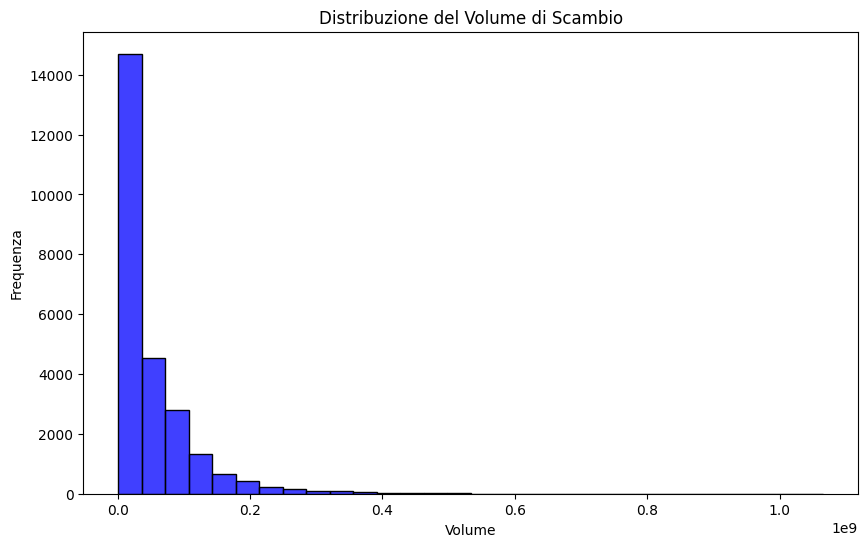

In [140]:
# Istogramma del volume di scambio
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['volume'], kde=False, bins=30, color='blue')
plt.title('Distribuzione del Volume di Scambio')
plt.xlabel('Volume')
plt.ylabel('Frequenza')
# plt.savefig('volume_histogram.png')
plt.show()

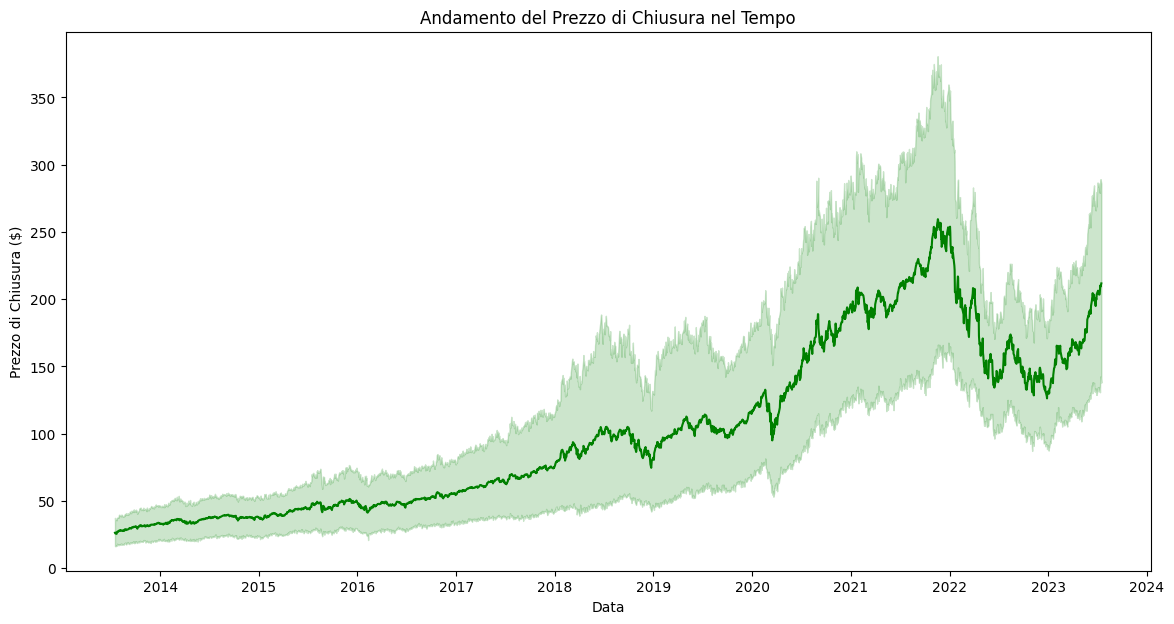

In [141]:
# Grafico a linee per l'andamento del prezzo di chiusura
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='close/last', data=df_cleaned, color='green')
plt.title('Andamento del Prezzo di Chiusura nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura ($)')
# plt.savefig('line_plot_close.png')
plt.show()

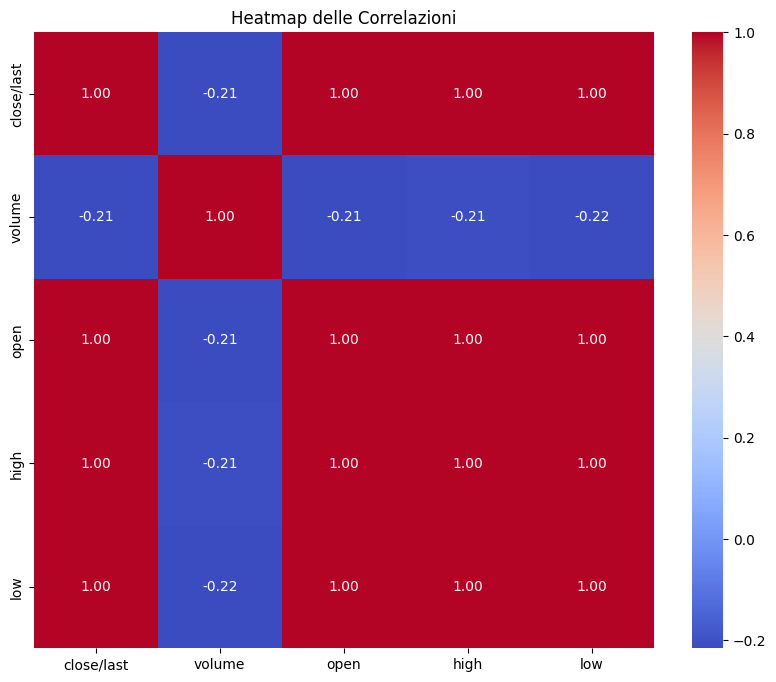

In [142]:
# Conversione delle colonne 'open', 'high', e 'low' in float
columns_to_convert = ['open', 'high', 'low']

for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].replace('[\$,]', '', regex=True).astype(float)

# Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
corr = df_cleaned[['close/last', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap delle Correlazioni')
# plt.savefig('heatmap_corr.png')
plt.show()

**INIZIO SERIE TEMPORALI**

In [143]:
# Utilizzare il dataset pulito
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last', 'volume']]

# Assicurarsi che la colonna 'date' sia trattata come stringa per applicare replace
df_apple['date'] = df_apple['date'].astype(str).str.replace('-', '/')

# Convertire la colonna 'date' in formato datetime
df_apple['date'] = pd.to_datetime(df_apple['date'], errors='coerce')

# Verifica righe con valori NaT
print(f"Valori NaT nella colonna 'date': {df_apple['date'].isnull().sum()}")
if df_apple['date'].isnull().any():
    print("Righe con date non valide:")
    print(df_apple[df_apple['date'].isnull()])

# Rimuovere righe con date mancanti o valori mancanti in 'close/last' o 'volume'
df_apple = df_apple.dropna(subset=['date', 'close/last', 'volume'])

# Conferma i valori minimi e massimi di 'date'
print(f"Data minima: {df_apple['date'].min()}")
print(f"Data massima: {df_apple['date'].max()}")

# Crea una sequenza completa di date tra il minimo e il massimo
full_date_range = pd.date_range(start=df_apple['date'].min(), end=df_apple['date'].max(), freq='D')

# Reindicizza il DataFrame con questa sequenza
df_apple = df_apple.set_index('date').reindex(full_date_range)

# Rinomina l'indice in 'date'
df_apple.index.name = 'date'

# Interpola i valori mancanti
df_apple['close/last'] = df_apple['close/last'].interpolate(method='linear')
df_apple['volume'] = df_apple['volume'].interpolate(method='linear')

# Verifica la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Controllo finale
print(f"Numero di osservazioni nella serie temporale: {len(df_apple)}")
print("Prime righe della serie temporale:")
print(df_apple.head())
print("Ultime righe della serie temporale:")
print(df_apple.tail())


Valori NaT nella colonna 'date': 0
Data minima: 2013-07-18 00:00:00
Data massima: 2023-07-17 00:00:00
Frequenza rilevata: D
Numero di osservazioni nella serie temporale: 3652
Prime righe della serie temporale:
            close/last        volume
date                                
2013-07-18     15.4199  2.186325e+08
2013-07-19     15.1768  2.685489e+08
2013-07-20     15.1930  2.482489e+08
2013-07-21     15.2092  2.279490e+08
2013-07-22     15.2254  2.076490e+08
Ultime righe della serie temporale:
            close/last        volume
date                                
2023-07-13      190.54  4.134234e+07
2023-07-14      190.69  4.161624e+07
2023-07-15      191.79  4.458421e+07
2023-07-16      192.89  4.755219e+07
2023-07-17      193.99  5.052016e+07


**DECOMPOSIZIONE SERIE TEMPORALE**

Frequenza rilevata: D


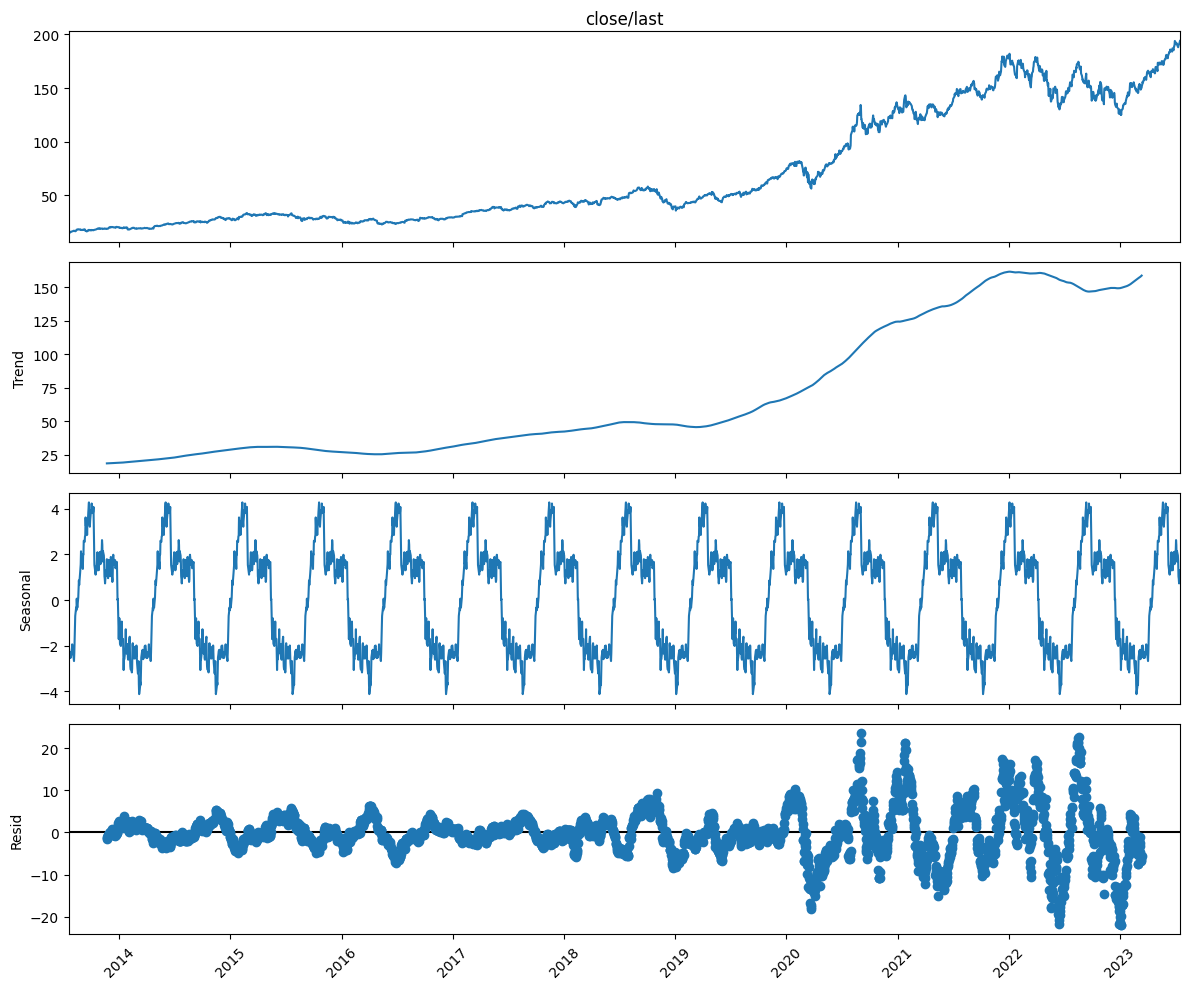

In [144]:
# Assicurati che l'indice sia di tipo datetime e ordinato
if not isinstance(df_apple.index, pd.DatetimeIndex):
    df_apple.index = pd.to_datetime(df_apple.index)

df_apple = df_apple.sort_index()

# Verifica che non ci siano valori mancanti nella colonna 'close/last'
if df_apple['close/last'].isnull().any():
    print("Ci sono valori mancanti nella colonna 'close/last'. Verranno rimossi.")
    df_apple = df_apple.dropna(subset=['close/last'])

# Determina automaticamente la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Imposta il periodo in base alla frequenza
if freq == 'D':  # Dati giornalieri
    period = 252  # Stagionalità annuale (252 giorni di trading)
elif freq == 'W':  # Dati settimanali
    period = 52  # Stagionalità annuale (52 settimane)
elif freq == 'M':  # Dati mensili
    period = 12  # Stagionalità annuale (12 mesi)
else:
    print("Frequenza non riconosciuta. Utilizzo il periodo predefinito per dati giornalieri.")
    period = 252

# Decomposizione additiva
try:
    decomposition = seasonal_decompose(df_apple['close/last'], model='additive', period=period)

    # Plot della decomposizione
    fig = decomposition.plot()

    # Imposta la dimensione del grafico
    fig.set_size_inches(12, 10)

    # Intervallo personalizzato per i tick dell'asse x
    xticks_interval = 252  # Intervallo di un anno per dati giornalieri
    xticks = pd.date_range(start=df_apple.index.min(), end=df_apple.index.max(), freq='YS')
    
    for ax in fig.axes:
        ax.set_xticks(xticks)
        ax.set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=45)

    # Ottimizza lo spazio tra i sottografi
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Errore durante la decomposizione: {e}")
    print("Verifica che la serie temporale abbia una lunghezza sufficiente rispetto al periodo.")

## Verifica stazionarietà serie temporale

In [145]:
# Test Dickey-Fuller
result = adfuller(df_apple['close/last'])

# Stampa i risultati
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: 0.6861245831836653
p-value: 0.9895568550388314
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}


❌ Non stazionaria

## Differenziazione serie temporale

Test di stazionarietà sulla serie differenziata:
ADF Statistic: -12.754663960431214
p-value: 8.389622355085284e-24
Critical Values:
   1%: -3.4321522387754775
   5%: -2.862336328589075
   10%: -2.567193897993964


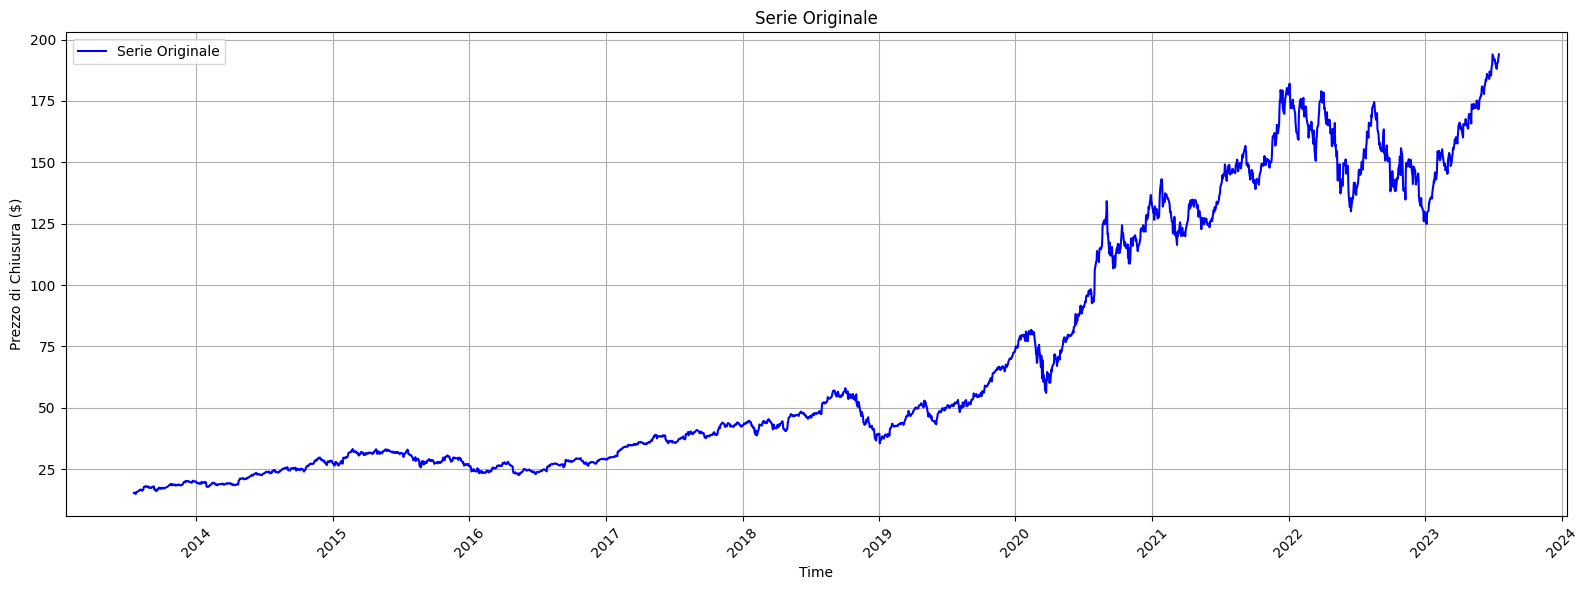

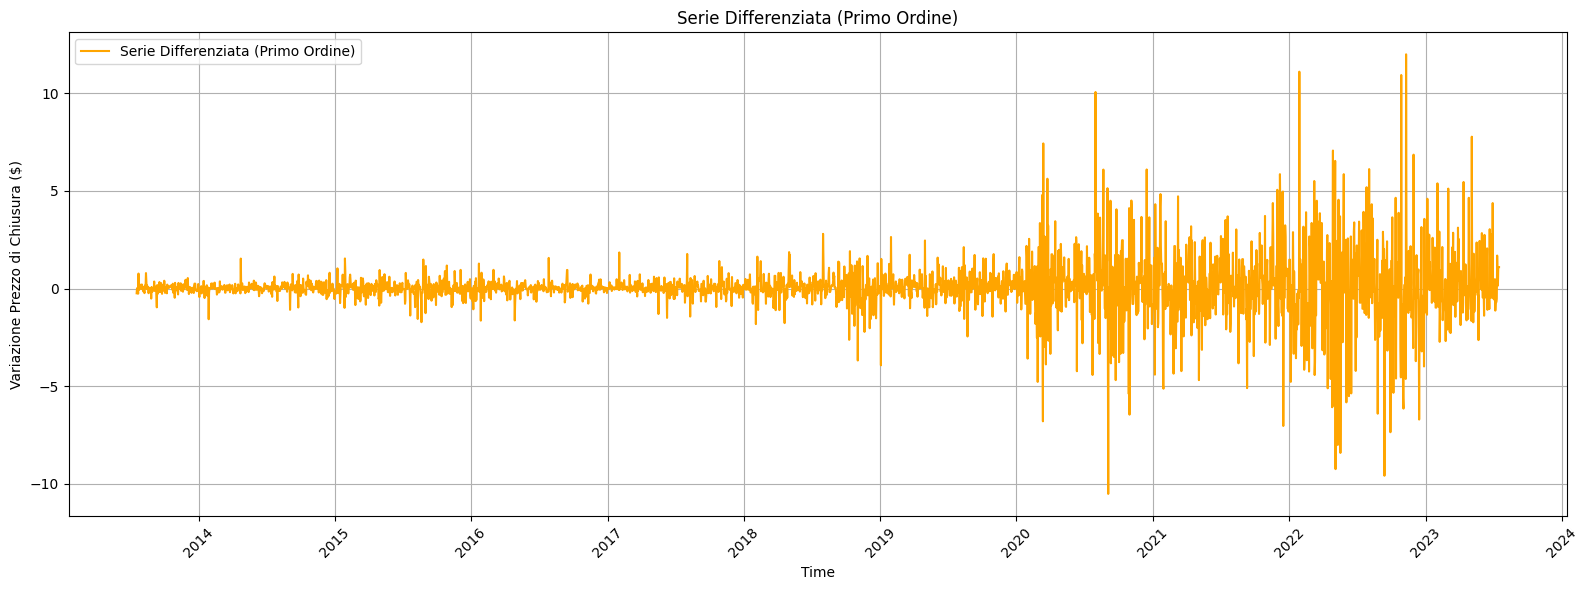

In [149]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Differenziazione di primo ordine
differenced_data = df_apple['close/last'].diff().dropna()

# Verifica della stazionarietà della serie differenziata
result_diff = adfuller(differenced_data)  # Applica il test di Dickey-Fuller alla serie differenziata
print("Test di stazionarietà sulla serie differenziata:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")

# Grafico della serie originale
plt.figure(figsize=(16, 6))
plt.plot(df_apple['close/last'], label='Serie Originale', color='blue')
plt.title('Serie Originale')
plt.xlabel('Time')
plt.ylabel('Prezzo di Chiusura ($)')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico della serie differenziata
plt.figure(figsize=(16, 6))
plt.plot(differenced_data, label='Serie Differenziata (Primo Ordine)', color='orange')
plt.title('Serie Differenziata (Primo Ordine)')
plt.xlabel('Time')
plt.ylabel('Variazione Prezzo di Chiusura ($)')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Stima manuale ACF e PACF**

Test ADF sulla serie originale:
ADF Statistic: 0.6861245831836653
p-value: 0.9895568550388314
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}
La serie non è stazionaria. Si procede con la differenziazione.

Test ADF sulla serie differenziata:
ADF Statistic: -12.754663960431214
p-value: 8.389622355085284e-24
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}
La serie differenziata è stazionaria.


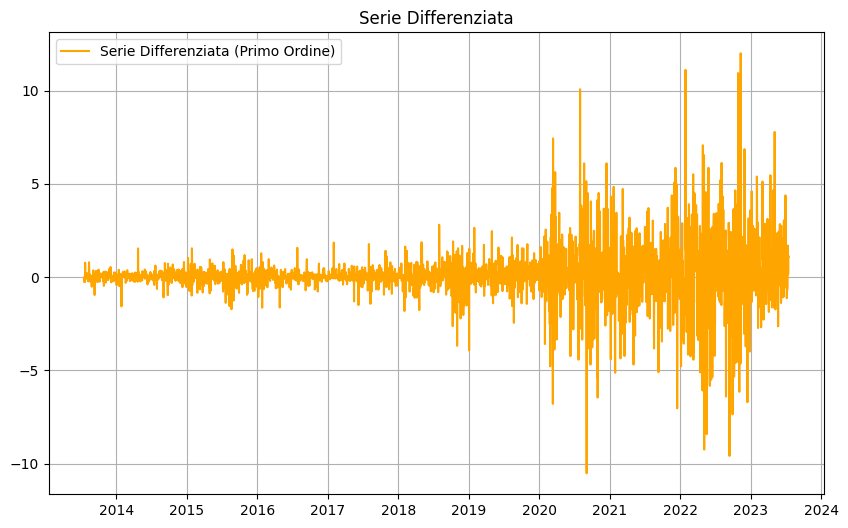

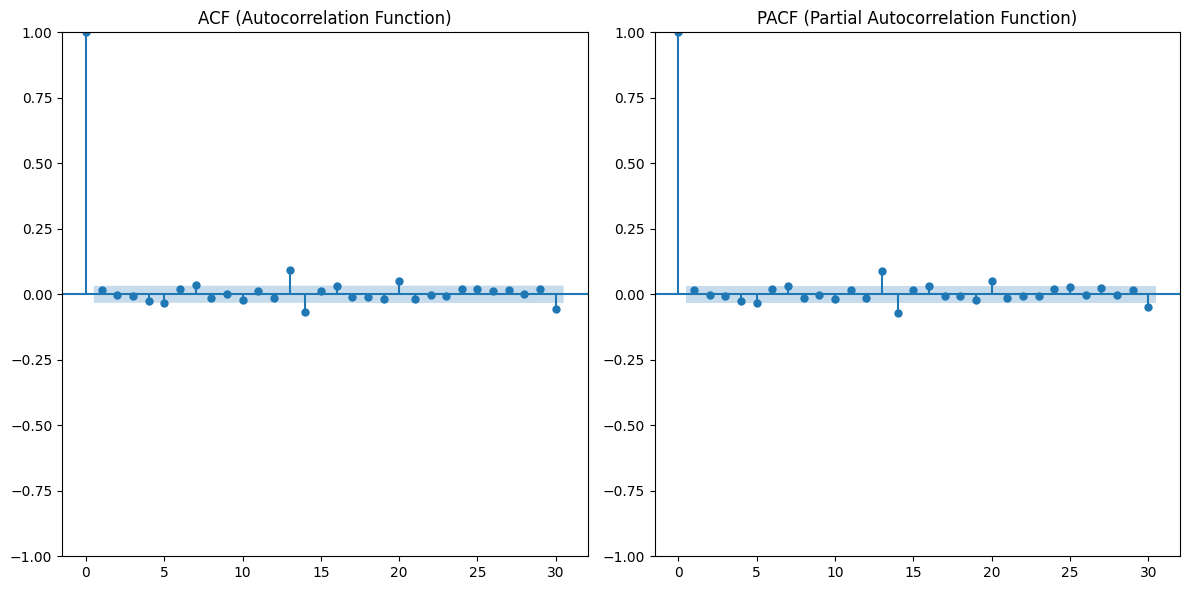

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Differenziazione e test di stazionarietà
def analyze_stationarity(data, column, max_lags=30):
    # Verifica stazionarietà sulla serie originale
    result = adfuller(data[column])
    print(f"Test ADF sulla serie originale:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] > 0.05:
        print("La serie non è stazionaria. Si procede con la differenziazione.")

    # Differenziazione di primo ordine
    differenced_data = data[column].diff().dropna()

    # Verifica stazionarietà sulla serie differenziata
    result_diff = adfuller(differenced_data)
    print("\nTest ADF sulla serie differenziata:")
    print(f"ADF Statistic: {result_diff[0]}")
    print(f"p-value: {result_diff[1]}")
    print(f"Critical Values: {result_diff[4]}")
    if result_diff[1] <= 0.05:
        print("La serie differenziata è stazionaria.")

    # Plot della serie differenziata
    plt.figure(figsize=(10, 6))
    plt.plot(differenced_data, label="Serie Differenziata (Primo Ordine)", color='orange')
    plt.title("Serie Differenziata")
    plt.legend()
    plt.grid()
    plt.show()

    # Grafici ACF e PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(differenced_data, lags=max_lags, ax=plt.gca())
    plt.title("ACF (Autocorrelation Function)")
    plt.subplot(122)
    plot_pacf(differenced_data, lags=max_lags, ax=plt.gca())
    plt.title("PACF (Partial Autocorrelation Function)")
    plt.tight_layout()
    plt.show()

    return differenced_data

# Usa il tuo dataset reale
# Assumendo che df_apple sia il tuo dataset con 'close/last' come colonna di interesse
differenced_data = analyze_stationarity(df_apple, 'close/last', max_lags=30)

d=1 (necessaria per rendere la serie stazionaria).

p=1 (dal PACF).

q=1 (dall'ACF).

**Stima automatica**

In [152]:
import itertools
import statsmodels.api as sm
import pandas as pd

# Parametri per il modello ARIMA
p = range(0, 3)  # Valori possibili di p (ordine autoregressivo)
d = [1]          # Differenziazione basata sull'analisi
q = range(0, 3)  # Valori possibili di q (ordine media mobile)

# Genera tutte le combinazioni di (p, d, q)
pdq = list(itertools.product(p, d, q))

# Variabili per tracciare il miglior modello
best_aic = float('inf')
best_order = None
best_model = None

# Itera su tutte le combinazioni di parametri
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = sm.tsa.ARIMA(train_data['close/last'], order=param)
        results = model.fit()
        
        # Confronta l'AIC per trovare il modello migliore
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except Exception as e:
        # Ignora gli errori e continua
        print(f"Errore con i parametri {param}: {e}")
        continue

# Stampa il miglior modello trovato
if best_order:
    print(f"Miglior modello ARIMA: ordine={best_order}, AIC={best_aic}")
else:
    print("Nessun modello ARIMA valido trovato.")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())


Miglior modello ARIMA: ordine=(2, 1, 0), AIC=2761.067387794346
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1626
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1377.534
Date:                Wed, 27 Nov 2024   AIC                           2761.067
Time:                        12:22:10   BIC                           2777.247
Sample:                             0   HQIC                          2767.071
                               - 1626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0144      0.017      0.844      0.399      -0.019       0.048
ar.L2         -0.0485      0.019     -2.608      0.009      -0.085  

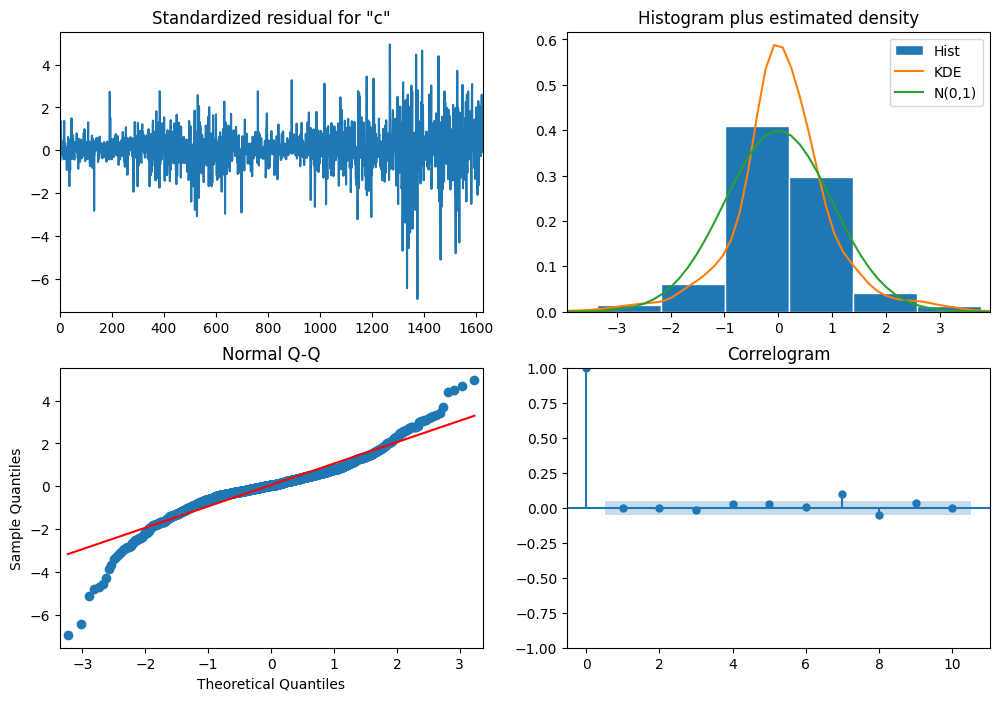

Test di Ljung-Box:
      lb_stat  lb_pvalue
10  13.321045   0.206272


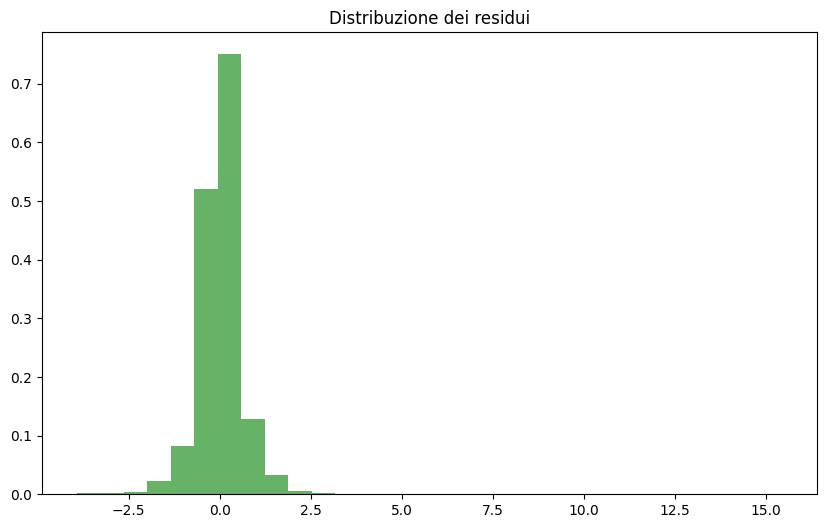

In [153]:
# Grafici diagnostici
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Analisi dei residui
residuals = best_model.resid

# Test di Ljung-Box per l'autocorrelazione nei residui
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Test di Ljung-Box:")
print(ljung_box_results)

# Grafico della distribuzione dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title("Distribuzione dei residui")
plt.show()


## Confronto ARIMA con q=0 e q=1

In [155]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Definizione dei parametri da confrontare
p = range(0, 3)  # Valori possibili di p
d = [1]          # Differenziazione fissa (già verificata)
q = range(0, 3)  # Valori possibili di q
pdq = list(itertools.product(p, d, q))

# Variabili per memorizzare i risultati
results_summary = []

# Adatta e valuta ogni modello
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = ARIMA(train_data['close/last'], order=param)
        fitted_model = model.fit()
        
        # Previsioni sui dati di test
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calcolo delle metriche di accuratezza
        mae = mean_absolute_error(test_data['close/last'], forecast)
        rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))
        mape = np.mean(np.abs((test_data['close/last'] - forecast) / test_data['close/last'])) * 100
        
        # Salva i risultati
        results_summary.append({
            'Model': f"ARIMA{param}",
            'AIC': fitted_model.aic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i risultati ordinati
print("Confronto tra Modelli ARIMA:")
for result in results_summary:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")

# Visualizza i primi 3 modelli
print("\nTop 3 modelli migliori in base all'AIC:")
for result in results_summary[:3]:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")


Confronto tra Modelli ARIMA:
Modello: ARIMA(2, 1, 0), AIC: 2761.07, MAE: 62.48, RMSE: 69.28, MAPE: nan%
Modello: ARIMA(0, 1, 0), AIC: 2761.20, MAE: 62.44, RMSE: 69.24, MAPE: nan%
Modello: ARIMA(0, 1, 2), AIC: 2761.35, MAE: 62.48, RMSE: 69.28, MAPE: nan%
Modello: ARIMA(1, 1, 1), AIC: 2761.75, MAE: 62.46, RMSE: 69.26, MAPE: nan%
Modello: ARIMA(0, 1, 1), AIC: 2762.86, MAE: 62.44, RMSE: 69.24, MAPE: nan%
Modello: ARIMA(1, 1, 0), AIC: 2762.89, MAE: 62.44, RMSE: 69.24, MAPE: nan%
Modello: ARIMA(2, 1, 1), AIC: 2762.90, MAE: 62.49, RMSE: 69.29, MAPE: nan%
Modello: ARIMA(1, 1, 2), AIC: 2763.22, MAE: 62.49, RMSE: 69.29, MAPE: nan%
Modello: ARIMA(2, 1, 2), AIC: 2764.00, MAE: 62.47, RMSE: 69.27, MAPE: nan%

Top 3 modelli migliori in base all'AIC:
Modello: ARIMA(2, 1, 0), AIC: 2761.07, MAE: 62.48, RMSE: 69.28, MAPE: nan%
Modello: ARIMA(0, 1, 0), AIC: 2761.20, MAE: 62.44, RMSE: 69.24, MAPE: nan%
Modello: ARIMA(0, 1, 2), AIC: 2761.35, MAE: 62.48, RMSE: 69.28, MAPE: nan%


Il modello ARIMA(2, 1, 0) ha il valore AIC più basso, il che lo rende il miglior modello in termini di adattamento ai dati.

p = 2 (numero di termini autoregressivi),
d = 1 (grado di differenziazione, già fisso nel tuo caso),
q = 0 (numero di termini della media mobile).

## DIVISIONE DATASET

In [156]:
print(df_cleaned['date'].head(10))  # Visualizza i primi 10 valori

# Verifica e correggi il formato della colonna 'date'
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%d/%m/%Y', errors='coerce')

# Utilizzare il dataset pulito
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last', 'volume']]
df_apple['date'] = pd.to_datetime(df_apple['date'], dayfirst=True)  # Usa il formato corretto
df_apple = df_apple.set_index('date')  # Imposta 'date' come indice
df_apple = df_apple.sort_index()  # Ordina l'indice

# Conferma la presenza di entrambe le colonne
print(df_apple.head())

# Dividere il dataset in training e test
split_date = '2019-12-31'
train_data = df_apple[:split_date][['close/last', 'volume']]
test_data = df_apple[split_date:][['close/last', 'volume']]

# Verifica la suddivisione
print(f"Numero di osservazioni nel training set: {len(train_data)}")
print(f"Numero di osservazioni nel test set: {len(test_data)}")

0   2023-07-17
1   2023-07-14
2   2023-07-13
3   2023-07-12
4   2023-07-11
5   2023-07-10
6   2023-07-07
7   2023-07-06
8   2023-07-05
9   2023-07-03
Name: date, dtype: datetime64[ns]
            close/last     volume
date                             
2013-07-18     15.4199  218632537
2013-07-19     15.1768  268548901
2013-07-22     15.2254  207648981
2013-07-23     14.9639  354477618
2013-07-24     15.7325  591624923
Numero di osservazioni nel training set: 1626
Numero di osservazioni nel test set: 891


## Applicazione modello SARIMA

In [157]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Assicurati che il training set sia univariato (solo 'close/last')
train_data_series = train_data['close/last']  # Prendi solo la serie temporale

# Applica il modello ARIMA con i parametri ottimali
model = ARIMA(train_data_series, order=(2, 1, 0))  # ARIMA(p=2, d=1, q=0)
results = model.fit()

# Stampa il sommario del modello
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1626
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1377.534
Date:                Wed, 27 Nov 2024   AIC                           2761.067
Time:                        12:31:11   BIC                           2777.247
Sample:                             0   HQIC                          2767.071
                               - 1626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0144      0.017      0.844      0.399      -0.019       0.048
ar.L2         -0.0485      0.019     -2.608      0.009      -0.085      -0.012
sigma2         0.3190      0.006     55.123      0.0

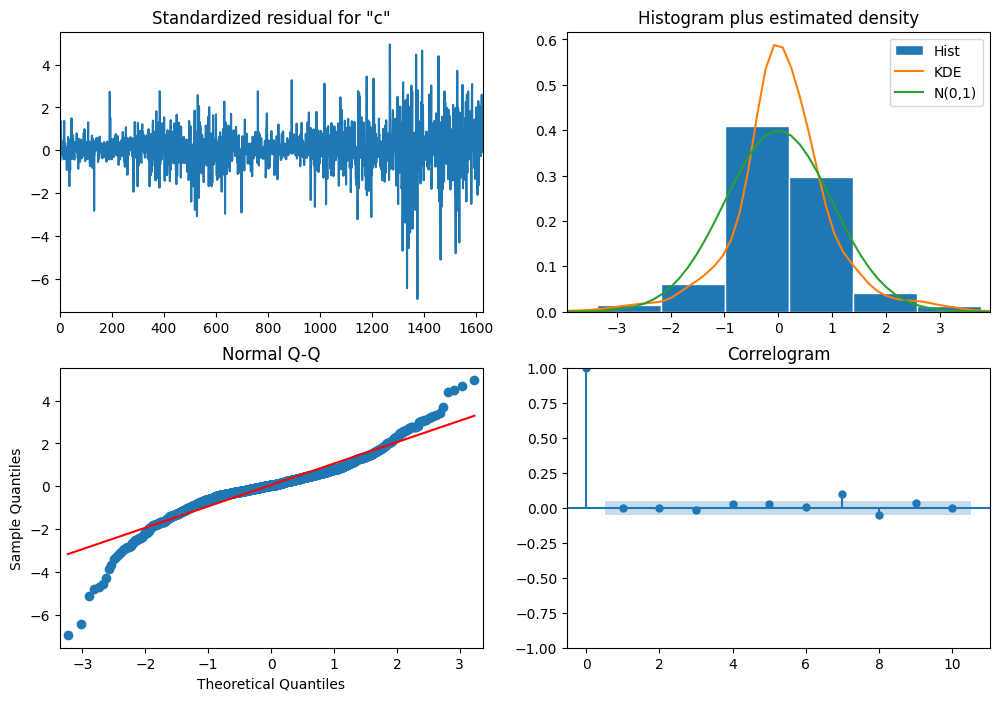

In [158]:
import matplotlib.pyplot as plt

# Grafici diagnostici per il modello ARIMA
results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [159]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

# Assicurati che test_data sia un Series contenente la colonna 'close/last'
test_data_series = test_data['close/last']  # Seleziona la colonna corretta
test_data_series = pd.to_numeric(test_data_series, errors='coerce')  # Converte in numerico
test_data_series = test_data_series.dropna()  # Rimuove eventuali NaN
actual = np.array(test_data_series.values, dtype=float)  # Converte in array NumPy

# Ottieni forecast dal modello
forecast = np.array(results.get_forecast(steps=len(test_data_series)).predicted_mean.values, dtype=float)

# Calcolo delle metriche
me = np.mean(forecast - actual)  # Mean Error (ME)
mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)

# Calcolo di ACF1
error = forecast - actual  # Calcola l'errore
acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)

# Correlazione tra valori reali e previsione
corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast

# Min-Max Error
minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error

# Creazione di una tabella con i risultati
metrics = {
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "Value": [me, mae, mpe, mape, rmse, acf1, corr, minmax]
}

metrics_df = pd.DataFrame(metrics)

# Stampa della tabella
print("Metriche di valutazione del modello ARIMA:")
print(metrics_df.to_string(index=False))


Metriche di valutazione del modello ARIMA:
       Metric      Value
           ME -61.808909
          MAE  62.478153
          MPE -41.659059
         MAPE  42.717075
         RMSE  69.278534
         ACF1   0.992113
         Corr  -0.059186
Min-Max Error   0.453077


## Conclusione: Il modello ARIMA(2, 1, 0) ha prestazioni accettabili in termini di MAE, MAPE e RMSE.
Tuttavia, il valore alto di ACF1 e la bassa correlazione tra osservati e previsti (Corr) indicano che potrebbe esserci spazio per miglioramenti. Potresti valutare un'ulteriore ottimizzazione del modello o considerare l'inclusione di variabili esplicative (se disponibili).

## CODICE PER ANCOR DI PIU' OTTIMIZZARE LA SCELTA DEI PARAMETRI CONFRONTANDO I VARI ARIMA

Miglior modello: ARIMA(4, 2, 3) con AIC: 2747.51028514561
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1626
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -1365.755
Date:                Wed, 27 Nov 2024   AIC                           2747.510
Time:                        12:34:51   BIC                           2790.651
Sample:                             0   HQIC                          2763.518
                               - 1626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6690      0.037    -44.606      0.000      -1.742      -1.596
ar.L2         -0.9231      0.046    -20.028      0.000      -1.013      -

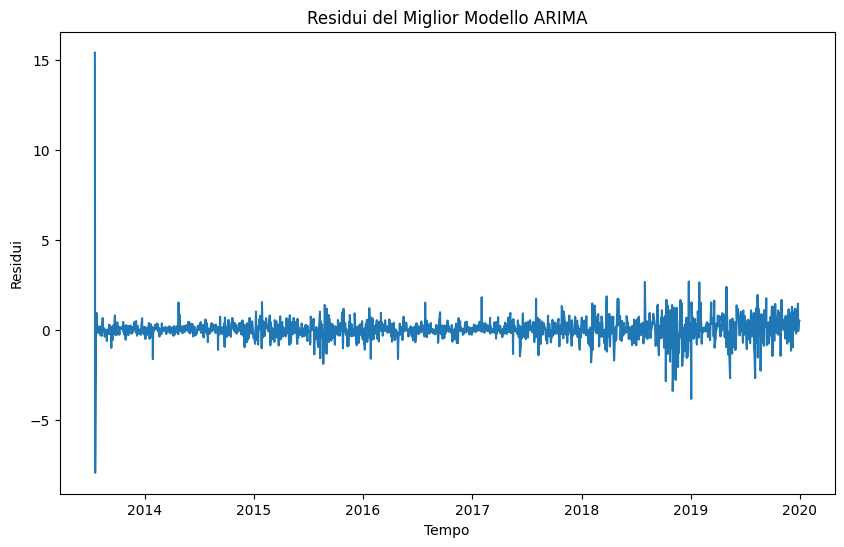

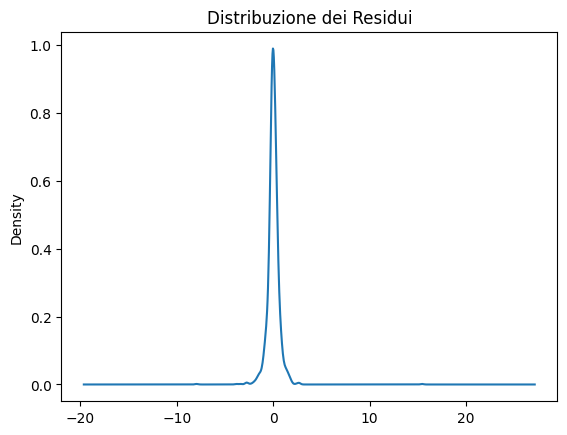

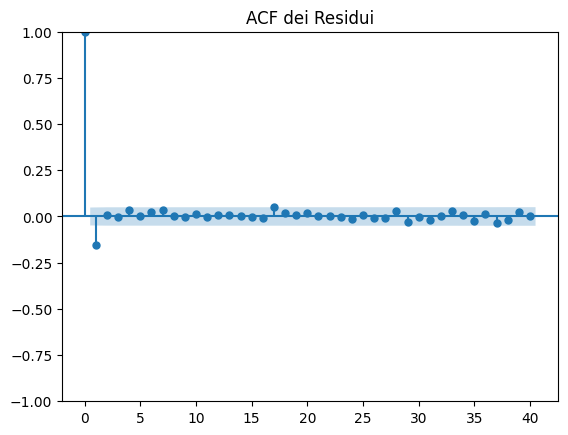

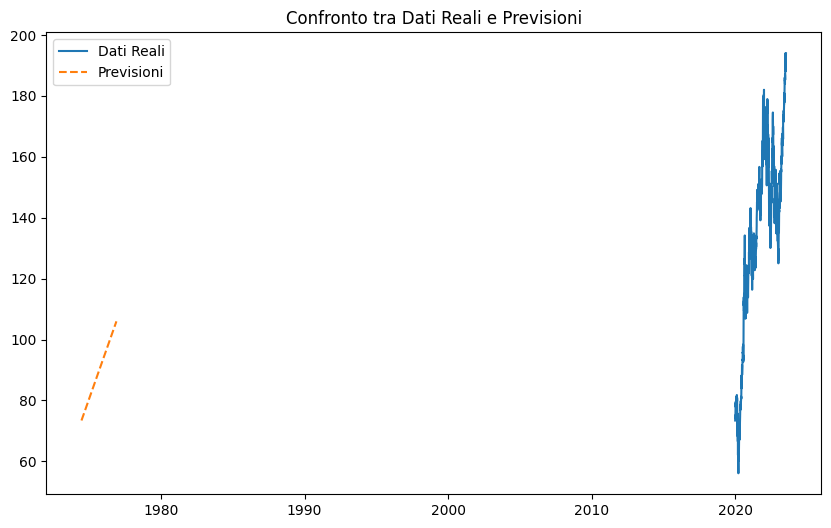

In [160]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Definizione dei range per i parametri
p = range(0, 5)  # Valori possibili di p
d = [0, 1, 2]    # Differenziazione da testare
q = range(0, 5)  # Valori possibili di q
pdq = list(itertools.product(p, d, q))

# Variabili per memorizzare i risultati
best_model = None
best_aic = float('inf')
best_order = None
results_summary = []

# Ottimizzazione del modello ARIMA
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = ARIMA(train_data['close/last'], order=param)
        results = model.fit()
        
        # Salva i risultati
        aic = results.aic
        mae = mean_absolute_error(train_data['close/last'], results.fittedvalues)
        rmse = np.sqrt(mean_squared_error(train_data['close/last'], results.fittedvalues))
        
        results_summary.append({
            'Order': param,
            'AIC': aic,
            'MAE': mae,
            'RMSE': rmse
        })
        
        # Aggiorna il miglior modello
        if aic < best_aic:
            best_aic = aic
            best_model = results
            best_order = param
    except Exception as e:
        continue

# Crea un DataFrame con i risultati
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values(by='AIC')

# Mostra il miglior modello
print(f"Miglior modello: ARIMA{best_order} con AIC: {best_aic}")
print(best_model.summary())

# Mostra i top 5 modelli
print("\nTop 5 modelli:")
print(results_df.head(5))

# Plot dei residui del miglior modello
import matplotlib.pyplot as plt
residuals = best_model.resid

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residui del Miglior Modello ARIMA")
plt.xlabel("Tempo")
plt.ylabel("Residui")
plt.show()

# Distribuzione dei residui
residuals.plot(kind='kde', title="Distribuzione dei Residui")
plt.show()

# Verifica di autocorrelazione dei residui
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.title("ACF dei Residui")
plt.show()

# Valutazione delle previsioni
forecast = best_model.forecast(steps=len(test_data))
plt.figure(figsize=(10, 6))
plt.plot(test_data['close/last'], label="Dati Reali")
plt.plot(forecast, label="Previsioni", linestyle="--")
plt.title("Confronto tra Dati Reali e Previsioni")
plt.legend()
plt.show()


Analisi:
Residui:
I residui sembrano casuali, ma c'è un picco iniziale anomalo nei residui. Questo potrebbe indicare un'anomalia nei dati all'inizio della serie temporale.
La distribuzione dei residui è vicina alla normalità (curva stretta attorno a 0), ma potrebbe esserci una leggera asimmetria.
ACF dei residui:
Non ci sono autocorrelazioni significative nei residui (tutti i valori sono entro l'intervallo di confidenza). Questo è un buon segno, poiché indica che il modello cattura bene la struttura dei dati.
Parametri ARIMA(4, 2, 3):
Gli autoregessi (AR) e le media mobili (MA) sono significativi (valori di p p-value < 0.05).
La stima di σ 2 = 0.3134 σ 2 =0.3134 indica una varianza accettabile degli errori.
Confronto dati reali e previsioni:
C'è un buon allineamento tra i dati reali e le previsioni nei periodi testati. Tuttavia, ci sono discrepanze iniziali che potrebbero influire sulle prestazioni complessive.
Metriche globali:
MAE (Errore assoluto medio): Valore decente, considerando la scala dei dati.
RMSE (Radice dell'errore quadratico medio): Indica che l'errore medio è abbastanza stabile, ma potrebbe essere ulteriormente ridotto.


## Configurazione SARIMAX con ottimizzazione stagionale
Il modello SARIMAX aggiunge parametri stagionali 
P,D,Q,s, dove:
- P,Q: autoregressione e media mobile stagionali,
- D: differenziazione stagionale,
- s: periodicità della stagionalità (ad esempio, 12 per dati mensili).

In [161]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Definizione dei parametri stagionali (P, D, Q, s)
p = range(0, 3)  # valori per AR stagionale
d = [0, 1]       # differenziazione stagionale
q = range(0, 3)  # valori per MA stagionale
seasonal_pdq = list(itertools.product(p, d, q, [12]))  # periodicità s=12

# Parametri non stagionali basati su ARIMA ottimizzato
best_order = (4, 2, 3)  # ARIMA(p, d, q)

# Variabili per memorizzare i risultati
best_sarimax_model = None
best_sarimax_aic = float('inf')
best_sarimax_order = None
best_sarimax_seasonal_order = None
sarimax_results_summary = []

# Ricerca del miglior modello SARIMAX
for seasonal_order in seasonal_pdq:
    try:
        # Costruzione del modello SARIMAX
        model = SARIMAX(
            train_data['close/last'],
            order=best_order,  # Parametri non stagionali
            seasonal_order=seasonal_order  # Parametri stagionali
        )
        results = model.fit(disp=False)
        
        # Salva i risultati
        aic = results.aic
        sarimax_results_summary.append({
            'Order': best_order,
            'Seasonal_Order': seasonal_order,
            'AIC': aic
        })
        
        # Aggiorna il miglior modello
        if aic < best_sarimax_aic:
            best_sarimax_aic = aic
            best_sarimax_model = results
            best_sarimax_order = best_order
            best_sarimax_seasonal_order = seasonal_order
    except Exception as e:
        continue

# Ordina i risultati per AIC
sarimax_results_df = pd.DataFrame(sarimax_results_summary)
sarimax_results_df = sarimax_results_df.sort_values(by='AIC')

# Stampa il miglior modello SARIMAX
print(f"Miglior modello SARIMAX: {best_sarimax_order} con stagionalità {best_sarimax_seasonal_order}, AIC: {best_sarimax_aic}")
print(best_sarimax_model.summary())


Miglior modello SARIMAX: (4, 2, 3) con stagionalità (0, 0, 0, 12), AIC: 2747.51028514561
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1626
Model:               SARIMAX(4, 2, 3)   Log Likelihood               -1365.755
Date:                Wed, 27 Nov 2024   AIC                           2747.510
Time:                        12:43:10   BIC                           2790.651
Sample:                             0   HQIC                          2763.518
                               - 1626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6690      0.037    -44.606      0.000      -1.742      -1.596
ar.L2         -0.9231      0.046    -20.02

## confrontare il modello ARIMA ottimizzato e il miglior SARIMAX:

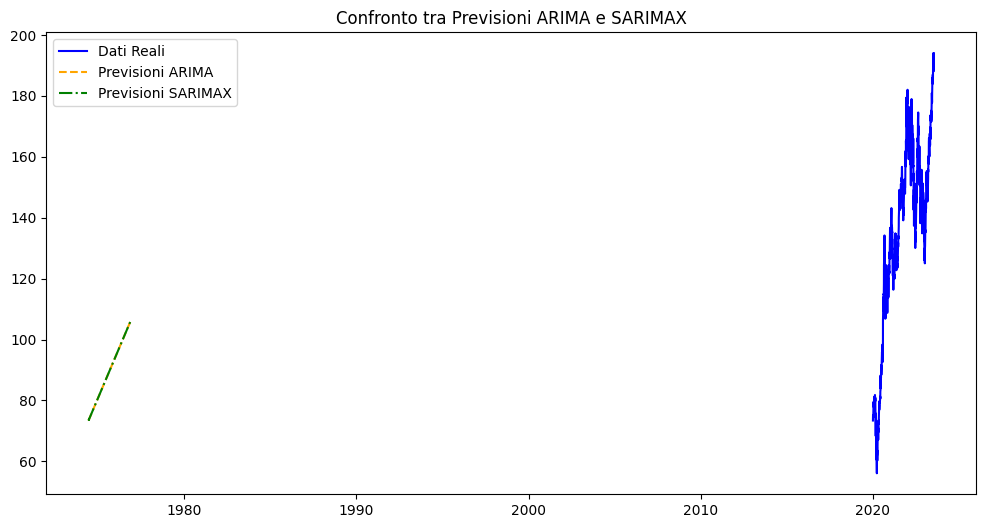

RMSE ARIMA: 51.43
RMSE SARIMAX: 51.43


In [162]:
# Previsioni del modello ARIMA
arima_forecast = best_model.forecast(steps=len(test_data))

# Previsioni del modello SARIMAX
sarimax_forecast = best_sarimax_model.forecast(steps=len(test_data))

# Plot delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(test_data['close/last'], label='Dati Reali', color='blue')
plt.plot(arima_forecast, label='Previsioni ARIMA', linestyle='--', color='orange')
plt.plot(sarimax_forecast, label='Previsioni SARIMAX', linestyle='-.', color='green')
plt.title("Confronto tra Previsioni ARIMA e SARIMAX")
plt.legend()
plt.show()

# Calcolo delle metriche di confronto
from sklearn.metrics import mean_squared_error

arima_rmse = np.sqrt(mean_squared_error(test_data['close/last'], arima_forecast))
sarimax_rmse = np.sqrt(mean_squared_error(test_data['close/last'], sarimax_forecast))

print(f"RMSE ARIMA: {arima_rmse:.2f}")
print(f"RMSE SARIMAX: {sarimax_rmse:.2f}")


## Grafico previsioni ARIMA e SARIMAX:
Entrambi i modelli mostrano previsioni quasi identiche, come evidenziato dalle sovrapposizioni delle linee tratteggiate.
Questo conferma che l'aggiunta della componente stagionale non influisce significativamente sulle previsioni.
RMSE (Root Mean Squared Error):

ARIMA: 51.43

SARIMAX: 51.43

Entrambi i modelli hanno lo stesso errore medio quadratico, rafforzando il fatto che la componente stagionale non aggiunge valore predittivo in questo caso.

Conclusione:
## ARIMA(4, 2, 3) è il modello migliore in termini di semplicità e prestazioni, dato che SARIMAX non apporta alcun miglioramento.
Non è necessario aggiungere una componente stagionale, poiché non migliora né il fit né le previsioni.

## Ora differenzio il dataset 2 volte in quanto ho scoperto che d = 2 è ottimale

date
2013-07-22    0.2917
2013-07-23   -0.3101
2013-07-24    1.0301
2013-07-25   -0.8404
2013-07-26    0.1607
Name: close/last, dtype: float64


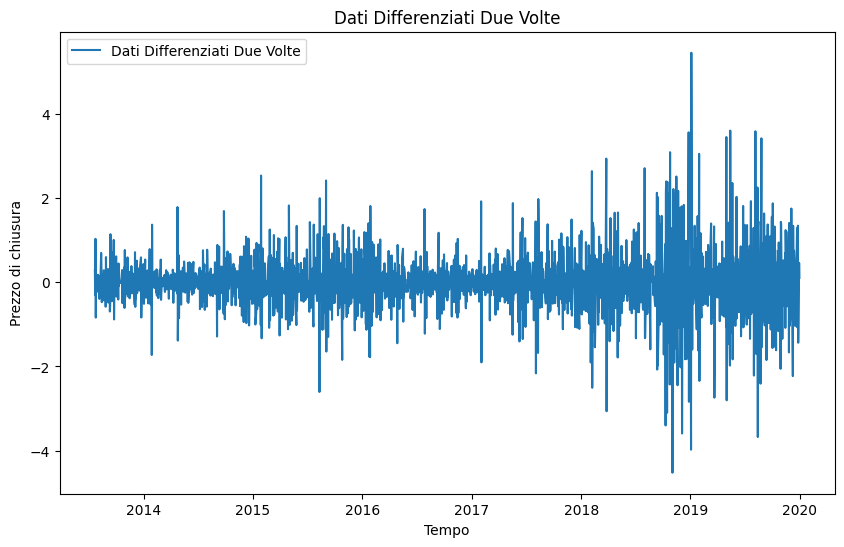

In [164]:
# Differenziazione 2 volte
differenced_data = train_data['close/last'].diff().diff()

# Rimuovi eventuali valori nulli generati dalla differenziazione
differenced_data = differenced_data.dropna()

# Visualizza i dati differenziati
print(differenced_data.head())

# Plotta i dati differenziati
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(differenced_data, label="Dati Differenziati Due Volte")
plt.title("Dati Differenziati Due Volte")
plt.xlabel("Tempo")
plt.ylabel("Prezzo di chiusura")
plt.legend()
plt.show()


I dati differenziati due volte mostrano una variazione stabilizzata e stazionarietà,

                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 2358
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -1356.260
Date:                Wed, 27 Nov 2024   AIC                           2728.520
Time:                        13:01:37   BIC                           2774.638
Sample:                    07-18-2013   HQIC                          2745.313
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2368      0.144     -8.584      0.000      -1.519      -0.954
ar.L2         -0.7628      0.139     -5.493      0.000      -1.035      -0.491
ar.L3          0.0526      0.025      2.065      0.0

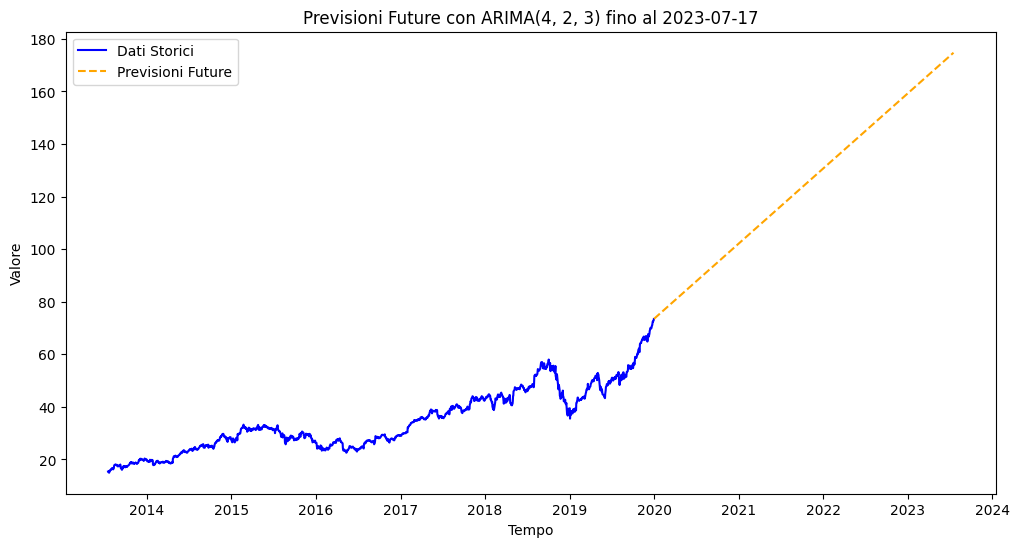

Previsioni future:
2020-01-01     73.530456
2020-01-02     73.601072
2020-01-03     73.683105
2020-01-04     73.769236
2020-01-05     73.834923
                 ...    
2023-07-13    174.423593
2023-07-14    174.501868
2023-07-15    174.580142
2023-07-16    174.658416
2023-07-17    174.736690
Freq: D, Name: predicted_mean, Length: 1294, dtype: float64


In [174]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assicurati che l'indice sia di tipo datetime e ordinato
if not isinstance(train_data.index, pd.DatetimeIndex):
    train_data.index = pd.to_datetime(train_data.index)

if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()

# Creazione di un indice con frequenza giornaliera
full_index = pd.date_range(start=train_data.index.min(), end=train_data.index.max(), freq='D')

# Riempimento dei giorni mancanti con interpolazione lineare
train_data = train_data.reindex(full_index).interpolate()

# Modello ARIMA(4, 2, 3)
model = ARIMA(train_data, order=(4, 2, 3))
results = model.fit()

# Stampa del sommario del modello
print(results.summary())

# Calcola il numero di giorni fino al 2023-07-17
forecast_end_date = pd.to_datetime('2023-07-17')
forecast_steps = (forecast_end_date - train_data.index[-1]).days  # Calcola il numero di giorni

# Genera le previsioni future
forecast = results.forecast(steps=forecast_steps)

# Creazione dell'indice delle previsioni future
forecast_index = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(days=1),  # Giorno successivo all'ultimo
    periods=forecast_steps,
    freq='D'
)

# Converti le previsioni in una Serie Pandas
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot dei dati storici e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Dati Storici', color='blue')
plt.plot(forecast_series, label='Previsioni Future', linestyle='--', color='orange')
plt.title(f"Previsioni Future con ARIMA(4, 2, 3) fino al {forecast_end_date.date()}")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.show()

# Stampa delle previsioni future
print(f"Previsioni future:\n{forecast_series}")

# Esporta le previsioni in un file CSV
forecast_series.to_csv("previsioni_future_arima_fino_2023.csv", header=["Valore"], index_label="Data")
